In [1]:
%matplotlib inline
import os
import xml.dom.minidom as minidom
import matplotlib.pyplot as plt
import pandas as pd
import datapackage
import ome_files
import ome_files.metadata as ofmd

In [2]:
def get_table(datapackage_fn, table_name):
    dp = datapackage.DataPackage(datapackage_fn)
    res_map = dict((_.descriptor["name"], _.local_data_path) for _ in dp.resources)
    return pd.read_csv(res_map[table_name])
    

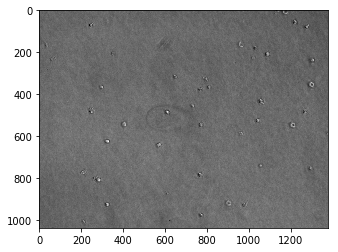

In [3]:
old_cwd = os.getcwd()
os.chdir(os.path.join("UGent", "BaF3"))
reader = ome_files.OMETIFFReader()
reader.set_id("9I5TT808_F00000010.companion.ome")
pixels = reader.open_array(0)
ome_xml = reader.get_ome_xml()
meta = ofmd.OMEXMLMetadata(ome_xml)
reader.close()
plt.imshow(pixels, cmap="gray")

In [4]:
cmso_annotations = [_ for _ in meta.get_map_annotations() if _.Namespace == "CMSO/dpkg"]
assert len(cmso_annotations) == 1
ann = cmso_annotations[0]
paths = ann.Value.get("FilePath")
print paths

[u'cellmia/datapackage.json', u'trackmate/datapackage.json']


In [5]:
# should we standardize col names? Or include .ini files in datapackage?
time_col = {
    "cellmia/datapackage.json": "time index",
    "trackmate/datapackage.json": "FRAME"
}
x_col = {
    "cellmia/datapackage.json": "cell col",
    "trackmate/datapackage.json": "POSITION_X"
}
y_col = {
    "cellmia/datapackage.json": "cell row",
    "trackmate/datapackage.json": "POSITION_Y"
}
dataframes = {}
for dp_fn in paths:
    df = get_table(dp_fn, "objects_table")
    t = time_col[dp_fn]
    dataframes[dp_fn] = df[df[t] == 0]
    print "\n%s:" % dp_fn
    print df.head()


cellmia/datapackage.json:
   ID of track  time index   cell row     cell col
0            1           0   2.187500  1170.187500
1            1           1   2.210526  1171.578947
2            1           2  14.333333  1168.717949
3            1           3  18.500000  1156.500000
4            1           4  28.166667  1163.114583

trackmate/datapackage.json:
   SPOT_ID  FRAME  POSITION_X  POSITION_Y
0     8192    103  409.890083  236.189919
1     8193    103  417.058552  240.041258
2     8194    103  300.704937  275.584738
3     8195    103   47.214200  300.671893
4     8196    103  442.750009  307.510006


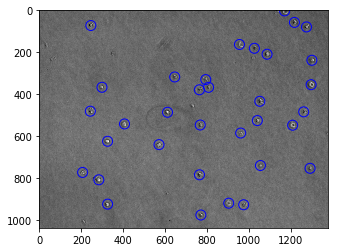

In [6]:
def plot_overlay(dp_fn, x_scale=1.0, y_scale=1.0):
    df = dataframes[dp_fn]
    x, y = x_scale * df[x_col[dp_fn]].values, y_scale * df[y_col[dp_fn]].values
    plt.scatter(x=x, y=y, s=100, edgecolors='b', facecolors='none')
    plt.imshow(pixels, cmap="gray")
    plt.show()
plot_overlay("cellmia/datapackage.json")

In [7]:
# TrackMate outputs coordinates as physical size
doc = minidom.parseString(ome_xml)
pixel_nodes = doc.getElementsByTagName("Pixels")
assert len(pixel_nodes) == 1
node = pixel_nodes[0]
x_scale = 1 / float(node.getAttribute("PhysicalSizeX"))
y_scale = 1 / float(node.getAttribute("PhysicalSizeY"))
print x_scale, y_scale

3.10559006211 3.10559006211


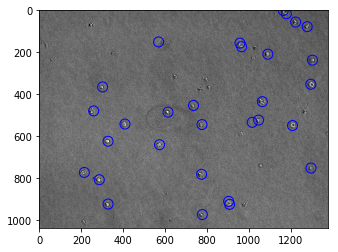

In [8]:
plot_overlay("trackmate/datapackage.json", x_scale, y_scale)

In [9]:
os.chdir(old_cwd)